In [1]:
import numpy as np

from seisLM.data_pipeline import seisbench_dataloaders as dataloaders
import pandas as pd
import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir
from seisLM.model.task_specific import phasepick_models


import json
import ml_collections
import torch


/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_config():

  config_path = gitdir() + '/seisLM/configs/phasepick/ethz_phasenet.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  return config
config = get_config()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = phasepick_models.PhaseNetLit(
  model_config=config.model_args,
  training_config=config.training_args).to(device)



data_name = 'ETHZ'
training_fraction = 0.05
batch_size = 1
for data_name in ['ETHZ', 'GEOFON', 'STEAD']:
  for training_fraction in [0.05, 0.1, 0.2, 0.5, 1.0]:
    train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
        model=model,
        data_names=data_name,
        batch_size=1,
        num_workers=config.data_args.get("num_workers", 8),
        training_fraction=training_fraction,
        cache=config.get("cache", None),
        prefetch_factor=config.get("prefetch_factor", 2),
    )

    num_train_samples = len(train_loader) * batch_size
    print(f"Data: {data_name}, Training fraction: {training_fraction}", )

2024-09-12 10:24:12,198 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


32

In [3]:
batch = {k: v.to(device) for k, v in batch.items()}
with torch.no_grad():
  loss = model.shared_step(batch)

In [4]:
with torch.no_grad():
  y_pred = model(batch["X"])
  print(y_pred[0])

  loss = model.loss(y_pred, batch["y"])
  print(loss)

tensor([[0.4212, 0.4212, 0.4203,  ..., 0.3679, 0.3671, 0.3670],
        [0.3288, 0.3288, 0.3310,  ..., 0.3341, 0.3362, 0.3362],
        [0.2499, 0.2499, 0.2487,  ..., 0.2979, 0.2967, 0.2967]],
       device='cuda:0')
tensor(1.2763, device='cuda:0', dtype=torch.float64)


In [5]:
with torch.no_grad():

  wav2vec2_outputs = model.model.wav2vec2(
    batch["X"],
    attention_mask=None,
    output_attentions=False,
    output_hidden_states=True,
  )

  wav2vec2_outputs


In [6]:
# num_layers = len(wav2vec2_outputs.hidden_states)

In [7]:
# lns = torch.nn.ModuleList(
#   [torch.nn.LayerNorm(model.model_config.hidden_size, eps=model.model_config.layer_norm_eps)
#   for i in range(num_layers)]
# )


In [8]:
# hidden_states = wav2vec2_outputs.hidden_states

# hidden_states = [layernorm(hidden_state) for (
#     hidden_state, layernorm) in zip(hidden_states, lns)
# ]


In [9]:
wav2vec2_outputs.hidden_states[0].shape

torch.Size([32, 749, 240])

In [10]:
rand_input = torch.randn(10, 749, 240)
ln = torch.nn.LayerNorm(240, eps=1e-5)

ln_out = ln(rand_input)



In [11]:
ln_out.std()

tensor(1.0000, grad_fn=<StdBackward0>)

In [13]:
import einops
import torch

# ln1 = torch.nn.LayerNorm(model.model_config.hidden_size + model.model_config.input_dim)
# ln2 = torch.nn.LayerNorm([3001, model.model_config.hidden_size + model.model_config.input_dim])

# ln1 = ln1.to(device)
# ln2 = ln2.to(device)

with torch.no_grad():
  input_values = batch["X"]
  hidden_states = model.model.get_wav2vec2_hidden_states(input_values)
  input_seq_length = input_values.shape[-1]

  # If seq_length of hidden_states and labels are not the same, we need to
  # interpolate the hidden_states to match the labels.
  if (hidden_states.shape[1] != input_seq_length):
    # change to [batch_size, hidden_size, seq_len]
    hidden_states = einops.rearrange(hidden_states, 'b l d -> b d l')
    hidden_states = torch.nn.functional.interpolate(
      hidden_states, size=input_seq_length,
      mode='linear', align_corners=False
    )
    hidden_states = einops.rearrange(hidden_states, 'b d l -> b l d')

  # Concatenate the hidden_states with the input_values

  hidden_states = torch.cat(
    [hidden_states,
      einops.rearrange(input_values, 'b d l -> b l d')], dim=-1)

  # hidden_states = model.model.hidden_dropout(hidden_states)

  # hidden_states = ln1(hidden_states)
  # hidden_states = ln2(hidden_states)
  # logits: [batch_size, seq_len, num_classes]
  logits = model.model.classifier(hidden_states)

  # logits: [batch_size, num_classes, seq_len]
  logits = einops.rearrange(logits, 'b l c -> b c l')

  # softmax over the classes
  pred =  torch.nn.functional.softmax(logits, dim=1)
  print(pred[0])

  loss = model.loss(pred, batch["y"])
  print(loss)


tensor([[0.4212, 0.4212, 0.4203,  ..., 0.3679, 0.3671, 0.3670],
        [0.3288, 0.3288, 0.3310,  ..., 0.3341, 0.3362, 0.3362],
        [0.2499, 0.2499, 0.2487,  ..., 0.2979, 0.2967, 0.2967]],
       device='cuda:0')
tensor(1.2763, device='cuda:0', dtype=torch.float64)


In [ ]:
hidden_states[2].shape

torch.Size([3001, 243])

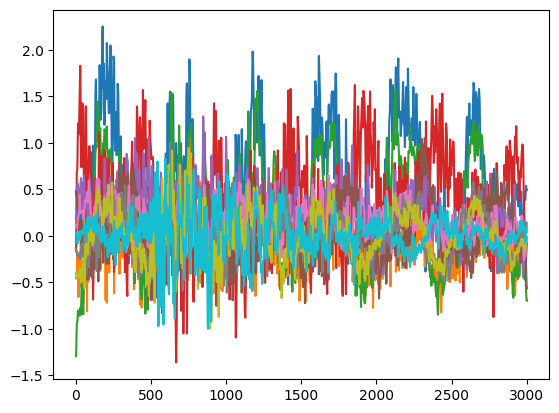

In [ ]:
num_visualizing_features = 10
plt.figure()
plt.plot(hidden_states[0].detach().cpu()[:, -num_visualizing_features:])

# plt.figure()
# plt.plot(ln1_hidden_states[0].detach().cpu()[:, -num_visualizing_features:])

# plt.figure()
# plt.plot(ln2_hidden_states[0].detach().cpu()[:, -num_visualizing_features:])